Strike: 0.50, Option Price: 0.006422
Strike: 0.55, Option Price: 0.008732
Strike: 0.60, Option Price: 0.011437
Strike: 0.65, Option Price: 0.014368
Strike: 0.70, Option Price: 0.017854
Strike: 0.75, Option Price: 0.021647
Strike: 0.80, Option Price: 0.025547
Strike: 0.85, Option Price: 0.029695
Strike: 0.90, Option Price: 0.034349

Estimated k: -0.054279
Intercept: 0.150149
R-squared: 0.973795


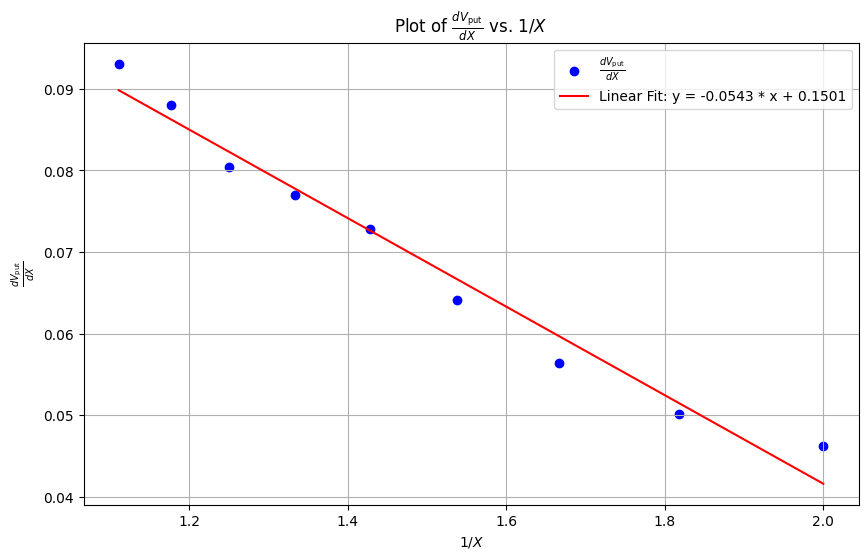

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
S0 = 1      # Initial asset price
r = 0.04        # Risk-free interest rate
sigma = 0.2     # Volatility
T = 10         # Time to maturity (in years)
M = 50          # Number of time steps
dt = T / M      # Time step size
N = 100000      # Number of simulation paths
Q = 0.05         # Cash payout for cash-or-nothing option

# Range of strike prices around Vg
Vg = 0.7  # Covenant threshold
strike_prices = np.linspace(0.5, 0.9, 9)  # Strike prices

def simulate_gbm_paths(S0, r, sigma, T, M, N):
    """Simulate GBM asset price paths."""
    dt = T / M
    # Preallocate array for efficiency
    S = np.zeros((N, M + 1))
    S[:, 0] = S0
    # Simulate paths
    for t in range(1, M + 1):
        Z = np.random.standard_normal(N)
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

def lsm_american_cash_or_nothing_put(S, X, r, dt, Q):
    """Price an American cash-or-nothing put option using LSM."""
    N, M = S.shape
    M -= 1  # Adjust for initial time step
    # Initialize option values
    V = np.zeros((N, M + 1))
    exercise = np.zeros((N, M + 1), dtype=bool)
    # At maturity, option value is Q if in the money
    V[:, M] = np.where(S[:, M] <= X, Q, 0)
    exercise[:, M] = S[:, M] <= X
    # Work backwards in time
    for t in range(M - 1, 0, -1):
        in_the_money = S[:, t] <= X
        # Immediate exercise value
        immediate_exercise = np.where(in_the_money, Q, 0)
        # Continuation value estimation using regression
        if np.any(in_the_money):
            # Features for regression (add constant term)
            X_train = S[in_the_money, t].reshape(-1, 1)
            y_train = V[in_the_money, t + 1] * np.exp(-r * dt)
            # Use polynomial basis functions (e.g., degree 2)
            poly_features = np.hstack((np.ones_like(X_train), X_train, X_train**2))
            # Fit regression model
            model = LinearRegression().fit(poly_features, y_train)
            # Predict continuation values
            continuation_value = model.predict(poly_features)
            # Decide whether to exercise
            exercise_now = immediate_exercise[in_the_money] > continuation_value
            # Update option values
            V[in_the_money, t] = np.where(exercise_now, immediate_exercise[in_the_money],
                                          V[in_the_money, t + 1] * np.exp(-r * dt))
            exercise[in_the_money, t] = exercise_now
            # For paths not in the money, carry forward the discounted value
            V[~in_the_money, t] = V[~in_the_money, t + 1] * np.exp(-r * dt)
        else:
            # If no paths are in the money, carry forward the discounted value
            V[:, t] = V[:, t + 1] * np.exp(-r * dt)
    # At t=0
    option_price = np.mean(V[:, 1] * np.exp(-r * dt))
    return option_price

# Calculate option prices for different strike prices
option_prices = []
for X in strike_prices:
    # Simulate asset paths
    S = simulate_gbm_paths(S0, r, sigma, T, M, N)
    # Price the option using LSM
    V_put = lsm_american_cash_or_nothing_put(S, X, r, dt, Q)
    option_prices.append(V_put)
    print(f"Strike: {X:.2f}, Option Price: {V_put:.6f}")

# Estimate the derivative dV_put/dX
option_prices = np.array(option_prices)
dX = strike_prices[1] - strike_prices[0]
dVdX = np.gradient(option_prices, dX)

# Analyze the relationship between dV_put/dX and 1/X
inverse_strikes = 1 / strike_prices

# Linear regression of dVdX vs. 1/X
reg_model = LinearRegression()
X_reg = inverse_strikes.reshape(-1, 1)
y_reg = dVdX
reg_model.fit(X_reg, y_reg)
k_estimated = reg_model.coef_[0]
intercept = reg_model.intercept_
R_squared = reg_model.score(X_reg, y_reg)

print(f"\nEstimated k: {k_estimated:.6f}")
print(f"Intercept: {intercept:.6f}")
print(f"R-squared: {R_squared:.6f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(inverse_strikes, dVdX, color='blue', label=r'$\frac{dV_{\mathrm{put}}}{dX}$')
plt.plot(inverse_strikes, reg_model.predict(X_reg), color='red', label=f'Linear Fit: y = {k_estimated:.4f} * x + {intercept:.4f}')
plt.xlabel(r'$1 / X$')
plt.ylabel(r'$\frac{dV_{\mathrm{put}}}{dX}$')
plt.title(r'Plot of $\frac{dV_{\mathrm{put}}}{dX}$ vs. $1 / X$')
plt.legend()
plt.grid(True)
plt.show()




